In [50]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
def read_data(path):
    df = pd.read_csv(path)
    df.drop('Unnamed: 0', axis=1, inplace=True)
    return df

In [3]:
def contain_nan(df):
    has_null = df.isna().any()
    is_null = df.isna().sum()
    for col in df.columns:
        print(f"{col:<25} {'True ' if has_null[col] else 'False'}  {is_null[col]}")

In [4]:
def select_features_KBest(X, y):
    X_new = SelectKBest(f_classif, k=2).fit_transform(X, y)
    return X_new

In [5]:
def select_features_Tree(X, y):
    clf = ExtraTreesClassifier(n_estimators=50)
    clf = clf.fit(X, y)
    print(clf.feature_importances_)
    model = SelectFromModel(clf, prefit=True)
    X_new = model.transform(X)
    return X_new

In [6]:
def split_data(X, y, test_size=0.2):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=27)
    return (X_train, X_test, y_train, y_test)

In [7]:
def OHE(df):
    encoder = OneHotEncoder()
    encoded_features = encoder.fit_transform(df[:, 0].reshape(-1, 1))
    df = np.delete(np.concatenate((df, encoded_features.toarray()), axis=1), np.s_[0:1], axis=1)
    return df

In [8]:
def plot_dist(TRAIN, TEST, LABEL1, LABEL2):
    for _ in TRAIN.columns[0:9]:
        plt.figure()
        sns.distplot(TRAIN[_], color='r', label=LABEL1);
        sns.distplot(TEST[_], label=LABEL2);
        plt.legend()

In [9]:
df = read_data('data/train_2.csv')

In [10]:
TEST = read_data('data/test_2.csv')

In [11]:
contain_nan(df)

trustLevel                False  0
totalScanTimeInSeconds    False  0
grandTotal                False  0
lineItemVoids             False  0
scansWithoutRegistration  False  0
quantityModifications     False  0
scannedLineItemsPerSecond False  0
valuePerSecond            False  0
lineItemVoidsPerPosition  False  0
fraud                     False  0


### Missing values are missing

In [12]:
df = df.loc[df['scannedLineItemsPerSecond'] < 1]
df = df.loc[df['valuePerSecond'] < 1]

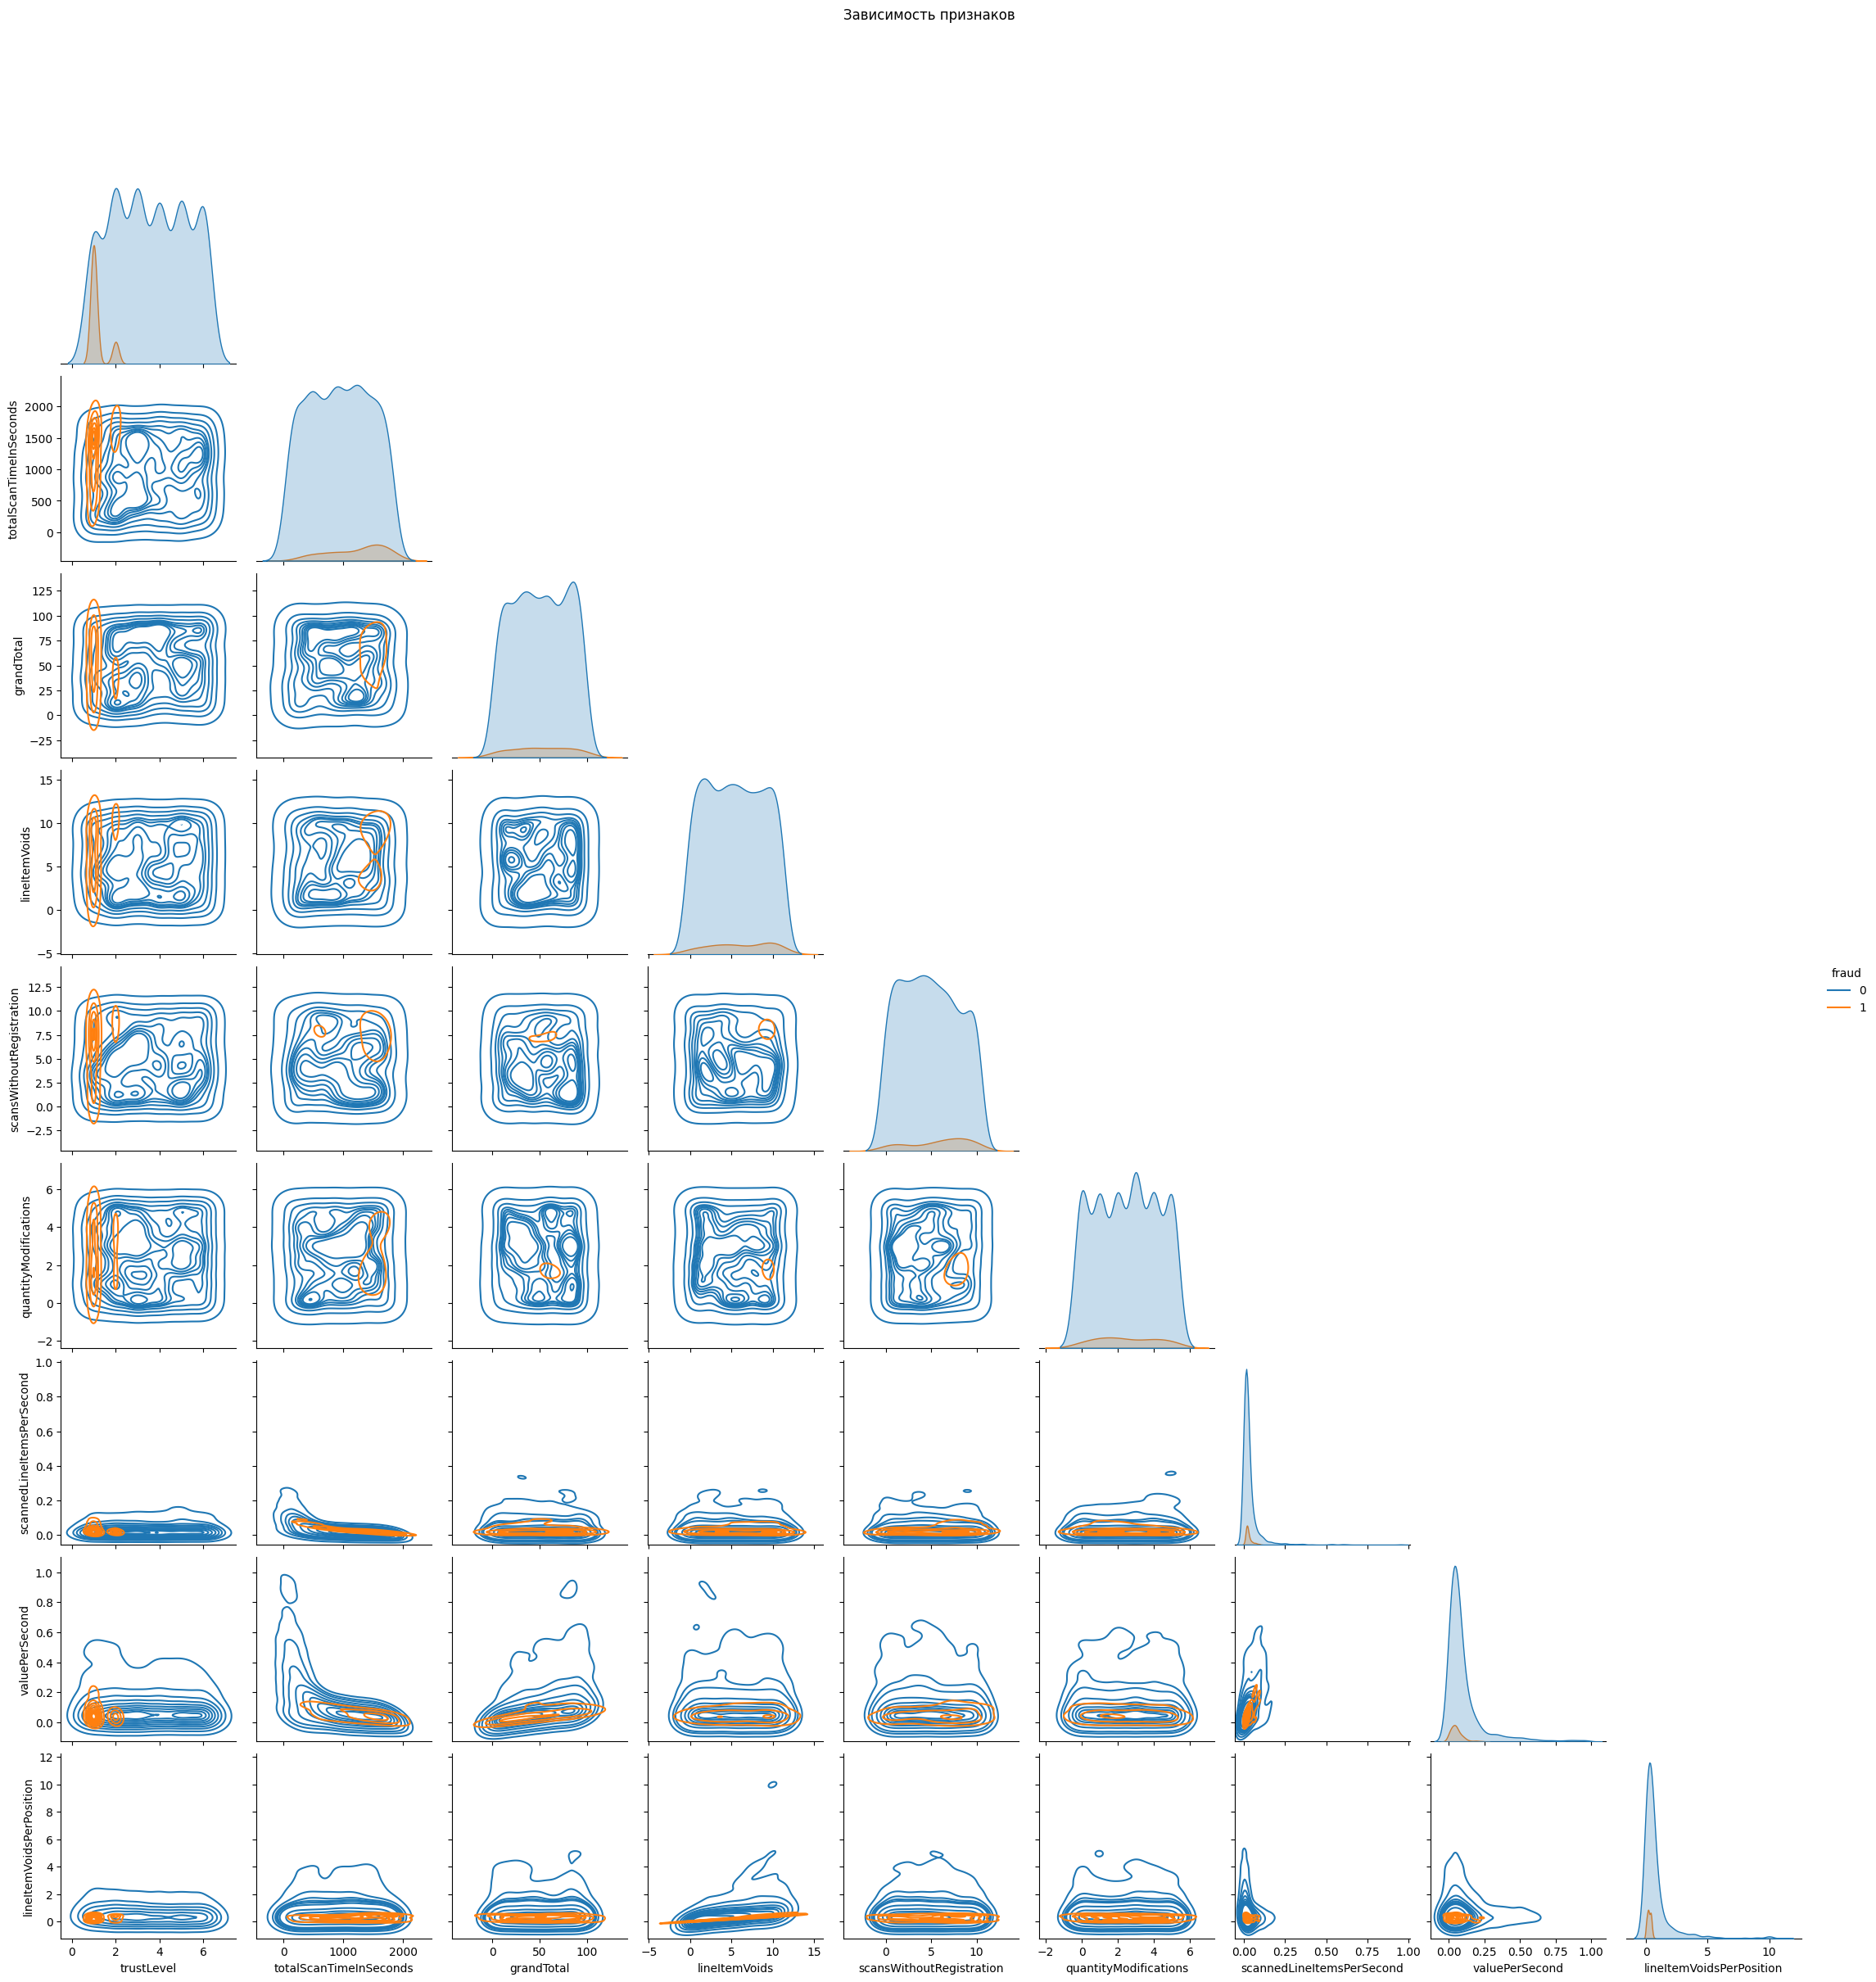

In [13]:
sns.pairplot(df, hue='fraud', corner=True, kind='kde').fig.suptitle('Зависимость признаков', y=1.08);

### TRAIN & TEST DISTRIBUTION

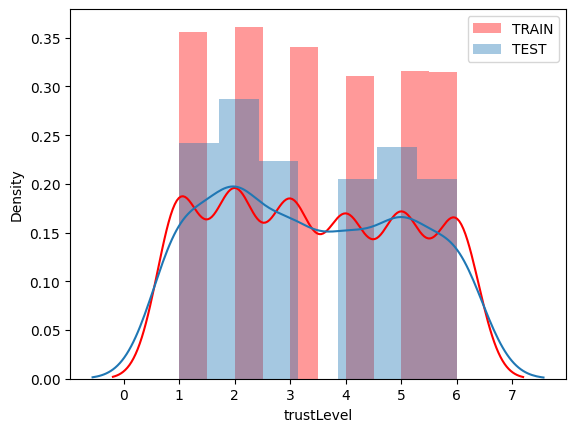

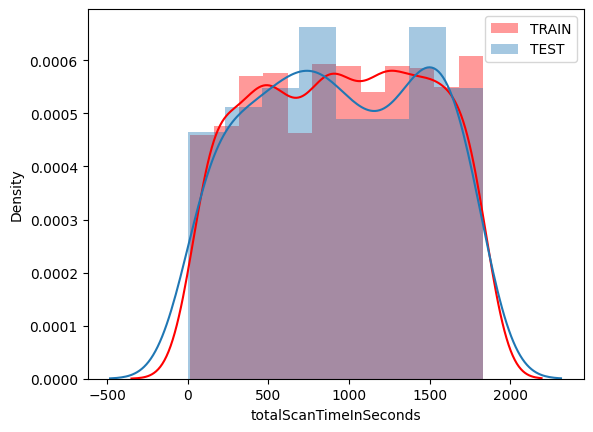

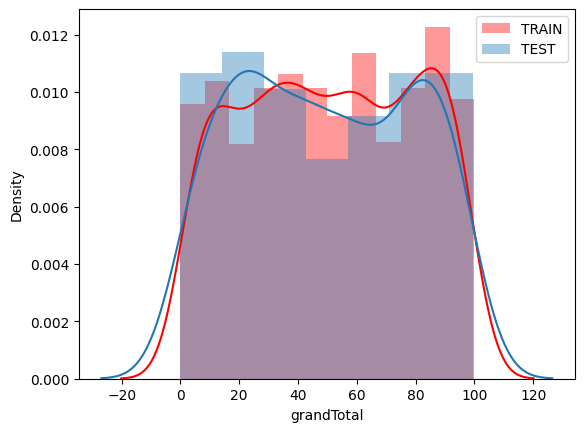

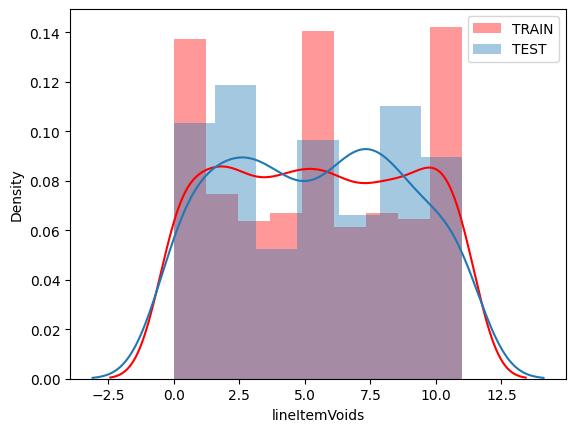

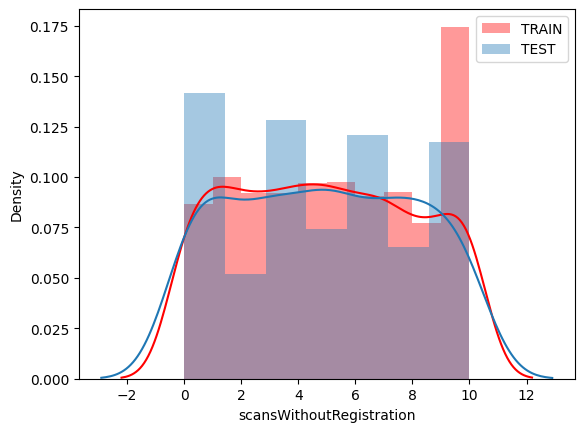

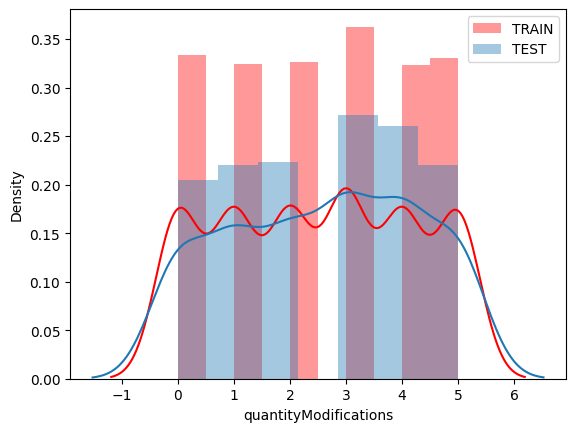

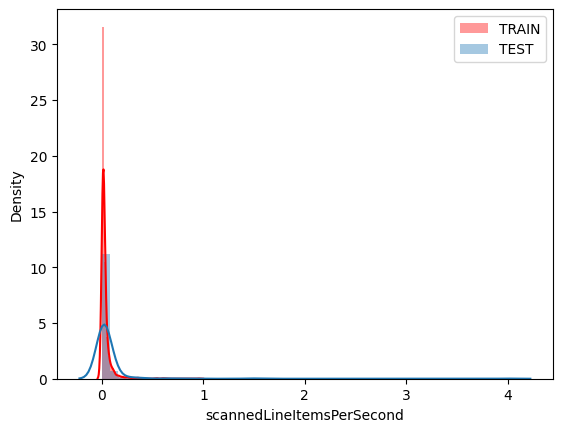

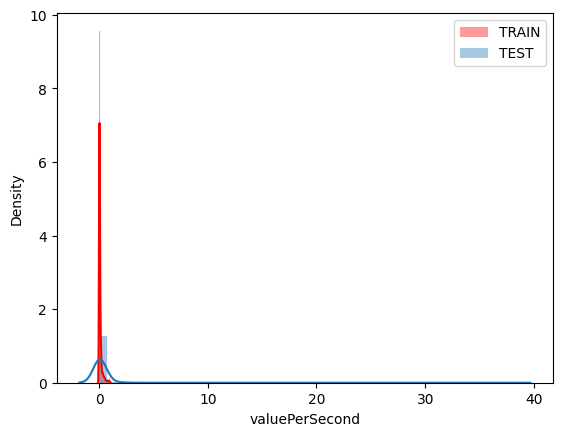

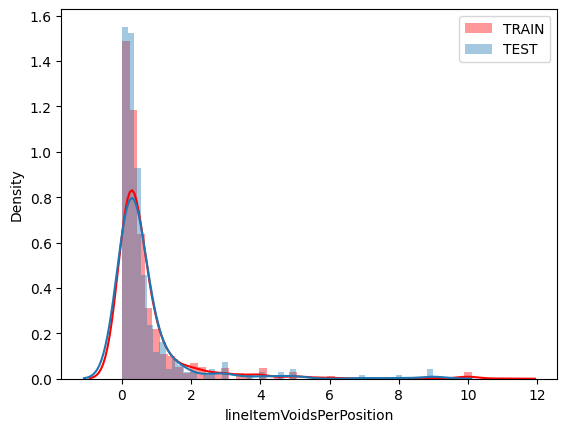

In [14]:
plot_dist(df, TEST, 'TRAIN', 'TEST')

In [15]:
TRAIN_0 = df.loc[df['fraud'] == 0]
TRAIN_1 = df.loc[df['fraud'] == 1]

### Distribution fraud & non fraud

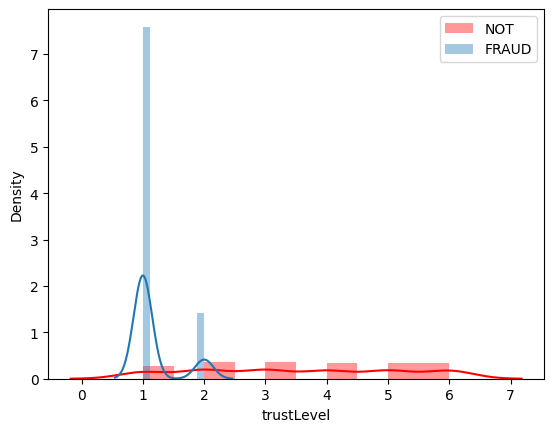

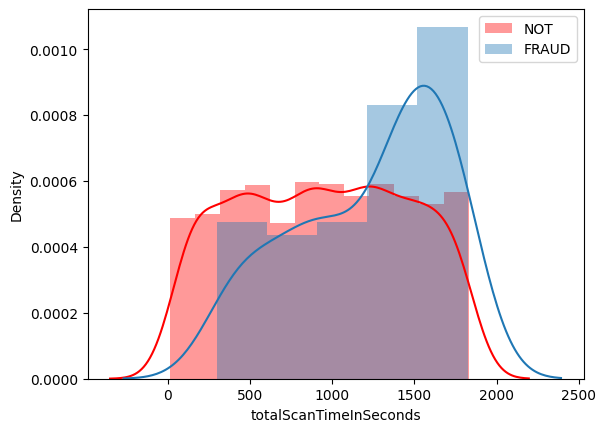

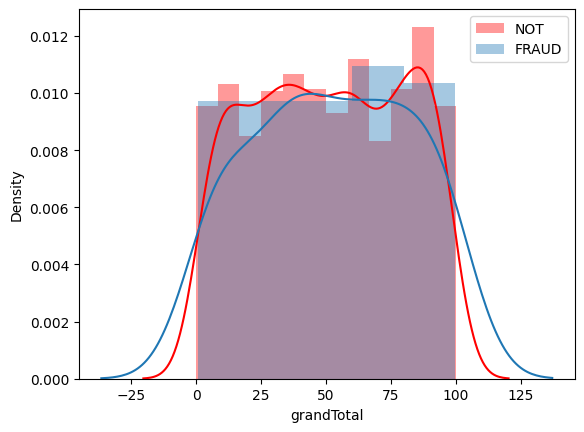

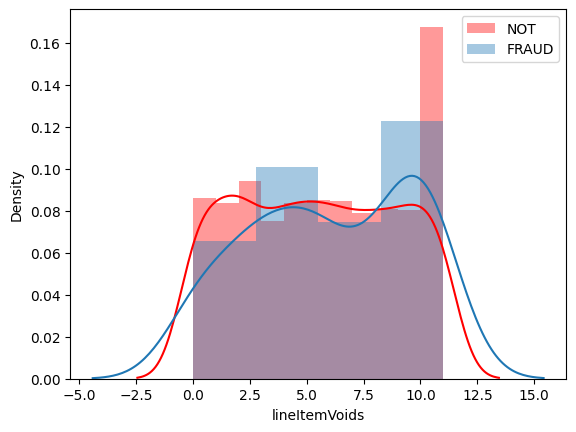

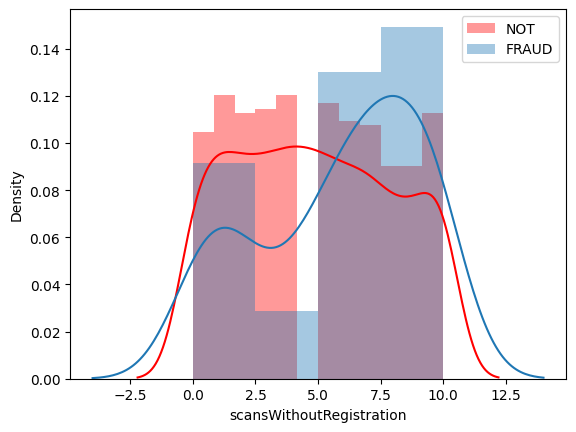

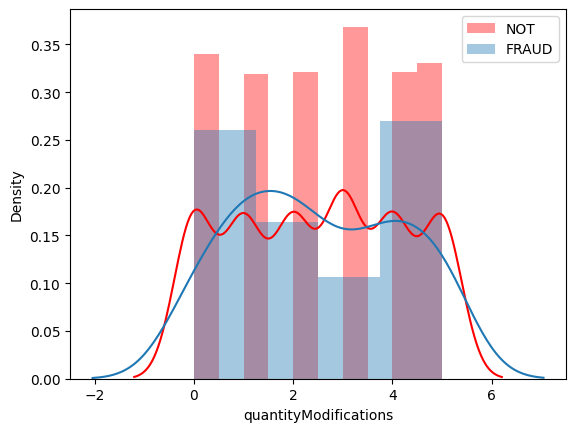

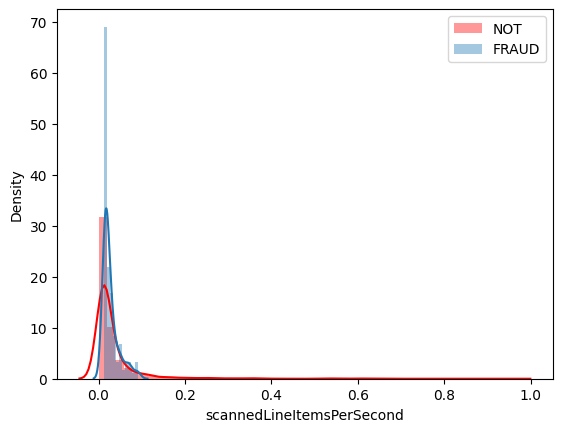

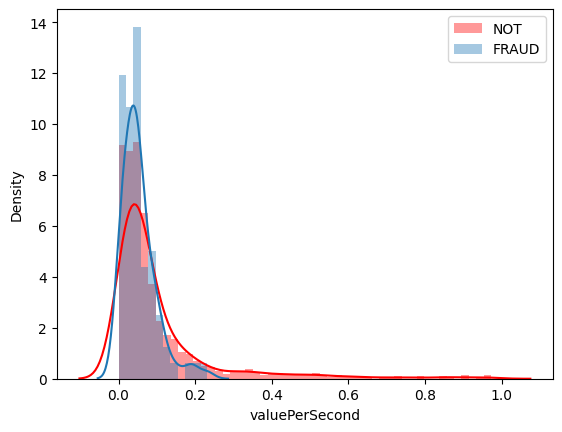

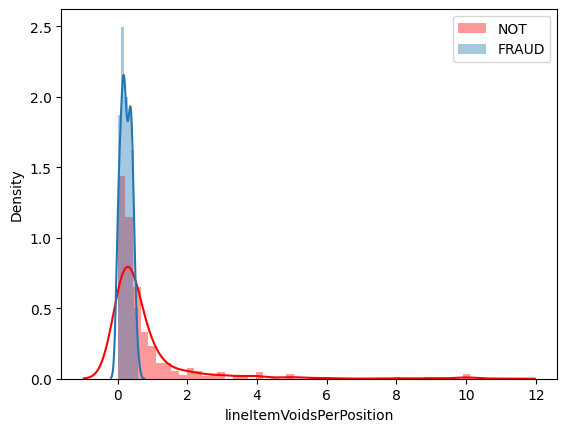

In [16]:
plot_dist(TRAIN_0, TRAIN_1, 'NOT', 'FRAUD')

### SelectKBest selected trustLevel & totalScanTimeInSecond

In [17]:
X = df.iloc[:, 0:9]
X = select_features_KBest(X, df[['fraud']])

In [18]:
X = df.iloc[:, 0:9]

### Tree-based feature selection: trustLevel & totalScanTimeInSecond & scannedLineItemsPerSecond

In [19]:
X = select_features_Tree(X, df['fraud'])

[0.24579063 0.11470793 0.06884907 0.08889379 0.07887873 0.05577032
 0.1659606  0.07040731 0.11074163]


In [20]:
X_train, X_test, y_train, y_test = split_data(df, df['fraud'])

In [21]:
X_train

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud
858,6,934,15.69,9,10,2,0.020343,0.016799,0.473684,0
1015,1,174,87.70,10,0,1,0.057471,0.504023,1.000000,0
344,3,471,96.93,9,3,4,0.044586,0.205796,0.428571,0
1218,5,973,48.59,10,1,1,0.015416,0.049938,0.666667,0
1006,2,1099,6.87,5,9,3,0.008189,0.006251,0.555556,0
...,...,...,...,...,...,...,...,...,...,...
1070,4,1692,70.17,3,9,3,0.010638,0.041472,0.166667,0
1348,6,407,62.09,7,3,3,0.039312,0.152555,0.437500,0
767,1,1158,99.82,10,10,0,0.022453,0.086200,0.384615,1
553,5,1825,61.79,10,2,4,0.000548,0.033858,10.000000,0


### Random Forest w/o hyperparameter selection

In [22]:
clf = RandomForestClassifier(n_estimators=150)
clf.fit(OHE(X_train[['trustLevel', 'totalScanTimeInSeconds', 'scannedLineItemsPerSecond', 'valuePerSecond']].to_numpy()), y_train)
predict = clf.predict(OHE(X_test[['trustLevel', 'totalScanTimeInSeconds', 'scannedLineItemsPerSecond', 'valuePerSecond']].to_numpy()))
print(accuracy_score(y_test, predict))

0.9795918367346939


In [23]:
cm = confusion_matrix(y_test, predict)
print(cm)
print('Score:', cm[1][1]*5 + cm[0][1]*(-5) + cm[1][0]*(-25))

[[276   1]
 [  5  12]]
Score: -70


In [24]:
df_to_send = read_data('data/test_2.csv')

In [25]:
df_to_send['fraud'] = clf.predict(OHE(read_data('data/test_2.csv')[['trustLevel', 'totalScanTimeInSeconds', 'scannedLineItemsPerSecond', 'valuePerSecond']].to_numpy()))

In [26]:
# df_to_send.to_csv('./data/res.csv')

### FCNN sucks

In [93]:
import models_
import importlib
importlib.reload(models_)
from models_ import FCNN

model = FCNN()
model.fit(OHE(X_train[['trustLevel', 'totalScanTimeInSeconds', 'scannedLineItemsPerSecond', 'valuePerSecond']].to_numpy()), y_train)

37/37 [==============================] - 1s 3ms/step - loss: 0.7094


In [94]:
p = model.predict(OHE(X_test[['trustLevel', 'totalScanTimeInSeconds', 'scannedLineItemsPerSecond', 'valuePerSecond']].to_numpy()))

10/10 [==============================] - 0s 1ms/step


In [95]:
p[p < 0.5] = 0
p[p >= 0.5] = 1

In [96]:
confusion_matrix(y_test, p)

array([[277,   0],
       [ 17,   0]], dtype=int64)

### XGBoost

In [101]:
import models_
import importlib
importlib.reload(models_)
from models_ import XGB

model = XGB()
model.fit(OHE(X_train[['trustLevel', 'totalScanTimeInSeconds', 'scannedLineItemsPerSecond', 'valuePerSecond']].to_numpy()), y_train)
best_estimator = model.best_estimator_
p = best_estimator.predict(OHE(X_test[['trustLevel', 'totalScanTimeInSeconds', 'scannedLineItemsPerSecond', 'valuePerSecond']].to_numpy()))

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=10; total time=   0.0s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=10; total time=   0.0s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=10; total time=   0.0s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=10; total time=   0.0s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=10; total time=   0.0s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time=   0.0s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time=   0.0s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time=   0.0s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time=   0.0s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time=   0.0s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   0.0s
[CV] END ...learning_rate=0.1, max_depth=3, n

In [102]:
accuracy_score(y_test, p)

0.9727891156462585

In [103]:
confusion_matrix(y_test, p)

array([[273,   4],
       [  4,  13]], dtype=int64)

### Random Forest w/ hyperparameter selection. MMM h-ta

In [104]:
import models_
import importlib
importlib.reload(models_)
from models_ import RFC

model = RFC()
model.fit(OHE(X_train[['trustLevel', 'totalScanTimeInSeconds', 'scannedLineItemsPerSecond', 'valuePerSecond']].to_numpy()), y_train)
best_estimator = model.best_estimator_
p = best_estimator.predict(OHE(X_test[['trustLevel', 'totalScanTimeInSeconds', 'scannedLineItemsPerSecond', 'valuePerSecond']].to_numpy()))

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
[CV] END ..max_depth=3, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END ..max_depth=3, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END ..max_depth=3, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END ..max_depth=3, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END ..max_depth=3, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END ..max_depth=3, min_samples_split=2, n_estimators=30; total time=   0.0s
[CV] END ..max_depth=3, min_samples_split=2, n_estimators=30; total time=   0.0s
[CV] END ..max_depth=3, min_samples_split=2, n_estimators=30; total time=   0.0s
[CV] END ..max_depth=3, min_samples_split=2, n_estimators=30; total time=   0.0s
[CV] END ..max_depth=3, min_samples_split=2, n_estimators=30; total time=   0.0s
[CV] END ..max_depth=3, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END ..max_depth=3, min_samples_split=2, 

In [105]:
accuracy_score(y_test, p)

0.9761904761904762

In [106]:
confusion_matrix(y_test, p)

array([[276,   1],
       [  6,  11]], dtype=int64)

### CATboost - Pretty good

In [107]:
import models_
import importlib
importlib.reload(models_)
from models_ import CAT

model = CAT()
model.fit((X_train[['trustLevel', 'totalScanTimeInSeconds', 'scannedLineItemsPerSecond', 'valuePerSecond']].to_numpy()), y_train)
best_estimator = model.best_estimator_
p = best_estimator.predict(X_test[['trustLevel', 'totalScanTimeInSeconds', 'scannedLineItemsPerSecond', 'valuePerSecond']].to_numpy())

Fitting 5 folds for each of 64 candidates, totalling 320 fits
0:	learn: 0.6862878	total: 147ms	remaining: 587ms
1:	learn: 0.6794524	total: 148ms	remaining: 222ms
2:	learn: 0.6724465	total: 149ms	remaining: 99.2ms
3:	learn: 0.6650727	total: 149ms	remaining: 37.3ms
4:	learn: 0.6588929	total: 150ms	remaining: 0us
[CV] END bootstrap_type=Bayesian, iterations=5, learning_rate=0.01; total time=   0.1s
0:	learn: 0.6862683	total: 1.44ms	remaining: 5.75ms
1:	learn: 0.6794083	total: 2.71ms	remaining: 4.07ms
2:	learn: 0.6727843	total: 3.87ms	remaining: 2.58ms
3:	learn: 0.6654218	total: 4.4ms	remaining: 1.1ms
4:	learn: 0.6592145	total: 5.63ms	remaining: 0us
[CV] END bootstrap_type=Bayesian, iterations=5, learning_rate=0.01; total time=   0.0s
0:	learn: 0.6862406	total: 1.3ms	remaining: 5.21ms
1:	learn: 0.6798246	total: 2.42ms	remaining: 3.63ms
2:	learn: 0.6731341	total: 3.46ms	remaining: 2.3ms
3:	learn: 0.6657592	total: 4.08ms	remaining: 1.02ms
4:	learn: 0.6596679	total: 5.34ms	remaining: 0us
[CV]

In [108]:
accuracy_score(y_test, p)

0.9863945578231292

In [109]:
confusion_matrix(y_test, p)

array([[276,   1],
       [  3,  14]], dtype=int64)